WARNING    The object 'neurongroup_2' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/v2/78z6fqbd3nz7_20tmkcx_wvr0000gn/T/ipykernel_96573/1798484765.py', line 28, in simulate_neural_network
    P = NeuronGroup(num_neurons, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms, method='exact') [brian2.core.base.unused_brian_object]


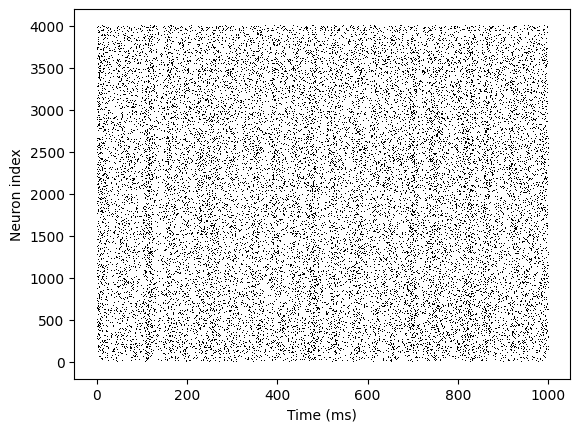

In [17]:
from brian2 import *

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV

eqs = '''
dv/dt  = (ge+gi+I_ext-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
I_ext: volt
'''

P = NeuronGroup(4000, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms, method='exact')
P.v = 'Vr + rand() * (Vt - Vr)'
P.ge = 0*mV
P.gi = 0*mV
P.I_ext = 0*mV

we = (60*0.27/10)*mV # excitatory synaptic weight (voltage)
wi = (-20*4.5/10)*mV # inhibitory synaptic weight
Ce = Synapses(P, P, on_pre='ge += we')
Ci = Synapses(P, P, on_pre='gi += wi')
Ce.connect('i<3200', p=0.02)
Ci.connect('i>=3200', p=0.02)

s_mon = SpikeMonitor(P)

run(1 * second)

plot(s_mon.t/ms, s_mon.i, ',k')
xlabel('Time (ms)')
ylabel('Neuron index')
show()


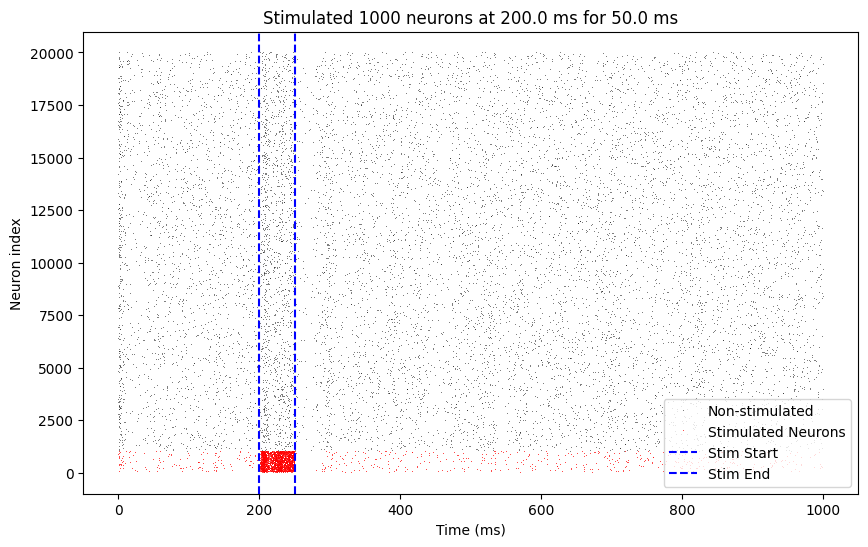

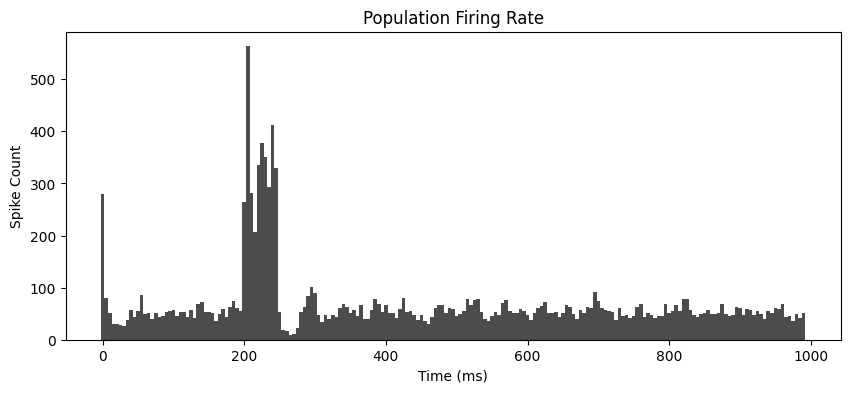

In [22]:
from brian2 import *

#Measurements every 10 milliseconds, 200 neurons

#Feedback stimulus (unpredictable): 150 mV at 5 hZ over 4 second period
#Feedback stimulus (predictable): 75 mV at 100 hZ for 100 mS

#Assume 50/50

# How Code is currently generating dummy data:

# def generate_dummy_data(NUM_CHANNELS=58, NUM_SAMPLES=1024):
#     time = np.linspace(0, 1, NUM_SAMPLES) # 1-second interval, 1024 samples
#     # for now, simulate as channel i being a sinusoid w/ freq 2pi i  + noise
#     channel_data = []
#     for i in range(NUM_CHANNELS):
#         voltage = np.sin(2 * np.pi * i * time)
#         channel_data.append(voltage)
#     channel_data = np.array(channel_data)
#     return time, channel_data

num_neurons=20000
stim_neurons=1000  # Number of neurons to stimulate
stim_start=200*ms # Stimulus begins
stim_duration=50*ms # Stimulus duration
stim_current=20*mV # External input current

def simulate_neural_network(num_neurons,stim_neurons,stim_start,stim_duration,stim_current):

    # Neuron and Synapse Parameters
    taum = 20*ms
    taue = 5*ms
    taui = 10*ms
    Vt = -50*mV
    Vr = -60*mV
    El = -49*mV

    # Define neuron equations with external input
    eqs = '''
    dv/dt  = (ge + gi + I_ext - (v - El)) / taum : volt (unless refractory)
    dge/dt = -ge / taue : volt
    dgi/dt = -gi / taui : volt
    I_ext : volt  # External current input
    '''

    # Create Neuron Group
    P = NeuronGroup(num_neurons, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms, method='exact')

    # Initialize neuron variables
    P.v = 'Vr + rand() * (Vt - Vr)'  # Random initial voltage
    P.ge = 0*mV
    P.gi = 0*mV
    P.I_ext = 0*mV  # No external input initially

    # Define Synaptic Weights
    we = (60 * 0.27 / 10) * mV  # Excitatory synaptic weight
    wi = (-20 * 4.5 / 10) * mV  # Inhibitory synaptic weight

    # Create Synapses
    Ce = Synapses(P, P, on_pre='ge += we')  # Excitatory synapses
    Ci = Synapses(P, P, on_pre='gi += wi')  # Inhibitory synapses

    # Connect Neurons Randomly
    Ce.connect('i < 10000', p=0.02)  # First 3200 are excitatory
    Ci.connect('i >= 10000', p=0.02) # Last 800 are inhibitory

    # Apply External Stimulation
    @network_operation(dt=1*ms)
    def apply_stimulation():
        if stim_start <= defaultclock.t < stim_start + stim_duration:
            P.I_ext[:stim_neurons] = stim_current  # Apply current to first `stim_neurons`
        else:
            P.I_ext[:] = 0*mV  # Reset external input after stimulus ends

    # Monitor Spikes
    s_mon = SpikeMonitor(P)

    # Create Network and Run Simulation
    net = Network(P, Ce, Ci, s_mon, apply_stimulation)
    net.run(1 * second)

    ### PLOTTING RESULTS ###
    figure(figsize=(10, 6))

    # Separate stimulated and non-stimulated neurons
    stimulated_neurons = s_mon.i < stim_neurons  # Boolean mask

    # Plot non-stimulated neurons in black
    plot(s_mon.t[~stimulated_neurons] / ms, s_mon.i[~stimulated_neurons], ',k', alpha=0.5, label="Non-stimulated")

    # Plot stimulated neurons in red
    plot(s_mon.t[stimulated_neurons] / ms, s_mon.i[stimulated_neurons], ',r', alpha=0.7, label="Stimulated Neurons")

    # Add Vertical Lines for Stimulus Start & End
    axvline(stim_start/ms, color='blue', linestyle='--', label="Stim Start")
    axvline((stim_start + stim_duration) / ms, color='blue', linestyle='--', label="Stim End")

    xlabel('Time (ms)')
    ylabel('Neuron index')
    title(f'Stimulated {stim_neurons} neurons at {stim_start/ms} ms for {stim_duration/ms} ms')
    legend()
    show()

    ### POPULATION FIRING RATE HISTOGRAM (PSTH) ###
    figure(figsize=(10, 4))
    bin_size = 5*ms  # Bin size for histogram
    hist, bins = np.histogram(s_mon.t/ms, bins=np.arange(0, 1000, bin_size/ms))

    bar(bins[:-1], hist, width=bin_size/ms, color='black', alpha=0.7)
    xlabel('Time (ms)')
    ylabel('Spike Count')
    title('Population Firing Rate')
    show()

# Call the function
simulate_neural_network(num_neurons,stim_neurons,stim_start,stim_duration,stim_current)